# **BA865 Final Project: Predicting Supreme Court Decisions**

# *Team: Eunjin Jeong, Ji Qi, Yesol Lee, Yongxian Lun*

# **1. Introduction**

* **Case background**: The Supreme court is the highest tribunal for all cases and interpretation of the Constitution or the laws in the United States. Supreme court decisions impact parties in each case, stakeholders, government and society. Supreme court decisions regulate individuals' life, rights and obligations. Therefore, predicting supreme court decision is critical that it helps stakeholder decision making.

* **Problem statement**: This project aims to predict whether petitioner will win or respondent will win in each case using multiple neural network models. This is a binary classification problem given winner index, party names, and case facts. Winner index indicates whether petitioner won or respondent won.

* **Dataset**: The source of this data is the Oyez project. Oyez project is a free law project from Cornell’s Legal Information Institute, Justia, and Chicago-Kent College of Law to archive Supreme Court data. We used dataset(task1_data.pkl) gathered by Mohammed Alsayed et all, in https://github.com/smitp415/CSCI_544_Final_Project.git


# **2. Statistics of dataset**

## Load the dataset

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV

import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [ ]:
# For displaying facts
pd.set_option('display.max_colwidth', None)

In [ ]:
# Load dataset as dataframe
df = pd.read_pickle('https://github.com/yesol-ba/portfolio/blob/main/Data/ba865_supreme%20court%20data_task1_data.pkl?raw=true') #publicly accessible data path

#df = pd.read_pickle('/content/task1_data.pkl') # Sally's Path
df.rename(columns={'Facts': 'facts'}, inplace=True)
df.drop(columns=['index'], inplace=True)
df.reset_index(inplace=True)

print(f'There are {len(df)} cases.')

There are 3464 cases.


In [ ]:
# Looking at the dataset
df.head(1)

,index,ID,name,href,first_party,second_party,winning_party,winner_index,facts
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,Jane Roe,Henry Wade,Jane Roe,0,"In 1970, Jane Roe (a fictional name used in court documents to protect the plaintiff’s identity) filed a lawsuit against Henry Wade, the district attorney of Dallas County, Texas, where she resided, challenging a Texas law making abortion illegal except by a doctor’s orders to save a woman’s life. In her lawsuit, Roe alleged that the state laws were unconstitutionally vague and abridged her right of personal privacy, protected by the First, Fourth, Fifth, Ninth, and Fourteenth Amendments."


In [ ]:
# There are 3 numerical columns and 6 object columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3464 entries, 0 to 3463
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          3464 non-null   int64 
 1   ID             3464 non-null   int64 
 2   name           3464 non-null   object
 3   href           3464 non-null   object
 4   first_party    3464 non-null   object
 5   second_party   3464 non-null   object
 6   winning_party  3464 non-null   object
 7   winner_index   3464 non-null   int64 
 8   facts          3464 non-null   object
dtypes: int64(3), object(6)
memory usage: 243.7+ KB


In [ ]:
# There isn't any missing values in this dataset
df.isna().sum()

index            0
ID               0
name             0
href             0
first_party      0
second_party     0
winning_party    0
winner_index     0
facts            0
dtype: int64

## Descriptive statistics

In [ ]:
avg_char = df['facts'].apply(lambda x: len(str(x))).mean()
print(f'Average facts character length: {avg_char:.0f}')

avg_word = df['facts'].apply(lambda x: len(str(x).split())).mean()
print(f'Average facts word length: {avg_word:.0f}')

del avg_char, avg_word

Average facts character length: 1179
Average facts word length: 189


In [ ]:
print(f'There are {len(df)} cases.')
print(f'There are {len(df[df["winner_index"]==0])} rows for class 0.')
print(f'There are {len(df[df["winner_index"]==1])} rows for class 1.')

There are 3464 cases.
There are 2114 rows for class 0.
There are 1350 rows for class 1.


In [ ]:
# Facts character stats
df['facts'].apply(lambda x: len(str(x))).describe()

count    3464.000000
mean     1179.302252
std       556.335680
min        95.000000
25%       784.000000
50%      1112.500000
75%      1496.000000
max      6108.000000
Name: facts, dtype: float64

In [ ]:
# Facts word stats
df['facts'].apply(lambda x: len(str(x).split())).describe()

count    3464.000000
mean      188.618938
std        91.496982
min        13.000000
25%       125.000000
50%       176.000000
75%       239.000000
max       974.000000
Name: facts, dtype: float64

In [ ]:
# Seqence Model Check (Not Pass)
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting integer encodings (which means we'll have a sequence of integers)
)
text_vectorization.adapt(df['facts'])
vectorized_facts = text_vectorization(df['facts'])


lengths = [len(x) for x in vectorized_facts]

print(f'The average fact in our data has {np.mean(lengths):.0f} words, and we have {len(df)} samples.\n')

print(f'The ratio of samples to average sample length is {(len(df)/np.mean(lengths)):.0f}. We are nowhere close to 1500.\n')

print(f'We need a larger dataset containing at least {(np.mean(lengths)*1500):.0f} samples.')


The average fact in our data has 1000 words, and we have 3464 samples.

The ratio of samples to average sample length is 3. We are nowhere close to 1500.

We need a larger dataset containing at least 1500000 samples.


# **3. Data preprocessing**

* **'winner_index' as Label**: 0 means first party(petitioner) wins and 1 means second party(respondent) wins. There are imbalances, so we will upsample minor class.

* **'first_party', 'second_party', 'facts' as Predictors**: We will use these features as predictors but do feature engineering to combine it.

* **'name', 'winning_party'**: ‘name’ consists of first party name and second party name, so we don’t use this feature as we already included party names in ‘facts’. ‘winning party’ is represented by ‘winner_index’, which is target variable.

* **'ID', 'href**': ‘ID’ was generated as an identifier when gathering data.  It doesn’t add a lot of values, and new IDs in test set that didn’t appear in train set might produce errors. ‘href’ is reference number grated after case, so we won’t use it as well.

## Feature engineering

* Checking whether party names are included in facts
  - 13.05% of facts don't contain the first party name
  - 17.18% of facts don't contain  the second party name
  - 1.93% of facts don't contain both first party the second party names
* Therefore, we decided to merge 'facts', 'first_party', and 'second_party' to preserve party information.
* Then, we will only use merged 'facts' as a predictor.

In [ ]:
name_pet = []
name_rep = []
for i in range(df.shape[0]):
  fact = df["facts"][i]
  petitioner = df["first_party"][i]
  respondent = df["second_party"][i]
  p = True
  r = True
  for _ in petitioner.split():
    if _ in fact:
      p = True
      break
    else:
      p = False
  if p == False: 
    #name_pet.append("Petitioner name not found in {}".format(i))
    name_pet.append(i)
  for _ in respondent.split():
    if _ in fact:
      r = True
      break
    else:
      r = False
  if r == False:
    #name_rep.append("Respondent name not found in {}".format(i))
    name_rep.append(i)

In [ ]:
perc_miss_pet = len(name_pet) / len(df) * 100
print('{:.2f}% of facts don\'t contain the first party name'.format(perc_miss_pet))

perc_miss_rep = len(name_rep) / len(df) * 100
print('{:.2f}% of facts don\'t contain the second party name'.format(perc_miss_rep))

perc_miss_both = len(set(set(name_pet) & set(name_rep))) / len(df) * 100
print('{:.2f}% of facts don\'t contain both first party the second party names'.format(perc_miss_both))

13.05% of facts don't contain the first party name
17.18% of facts don't contain the second party name
1.93% of facts don't contain both first party the second party names


In [ ]:
# Combining first party and second party with facts
df['facts'] = df['first_party']+' '+df['second_party']+' '+df['facts']

In [ ]:
df['facts'][50]

'United States Robinson A police officer pulled over and arrested Robinson for operating an automobile without a valid permit. The officer then frisked Robinson and discovered a crumpled cigarette package containing fourteen vials of heroin in his pocket.'

## Imbalance in Label class
* winner_index

0    2114
1    1350
Name: winner_index, dtype: int64


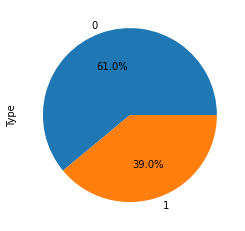

In [ ]:
print(df["winner_index"].value_counts())

df.groupby('winner_index').size().plot(kind='pie',
                                       y = "winner_index",
                                       label = "Type",
                                       autopct='%1.1f%%')

## Train-Test split

* We split train-test before upsampling to avoid duplicated rows in each set

In [ ]:
# Perform an 80-20 split for training and testing data
X_train, X_test, \
y_train, y_test = train_test_split(
    df[['winner_index', 'facts']],
    df['winner_index'],
    test_size=0.2,
    stratify=df['winner_index'],
    random_state=865
)

In [ ]:
petitioner = X_train[X_train["winner_index"] == 0]
respondent = X_train[X_train["winner_index"] == 1]
print(petitioner.shape)
print(respondent.shape)

(1691, 2)
(1080, 2)


## Upsampling train data

* We upsampled minor class, which is winner index 0 (respondent winning) using sklearn resample. 
* Eventually got 1689 cases in each class and shuffled the rows.

In [ ]:
from sklearn.utils import resample
upsample_respondent = resample(respondent,
             replace=True,
             n_samples=len(petitioner),
             random_state=865)

1    1691
0    1691
Name: winner_index, dtype: int64


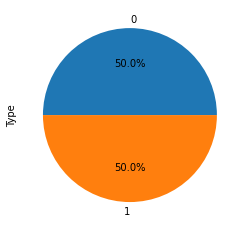

In [ ]:
upsample_train = pd.concat([upsample_respondent, petitioner])

print(upsample_train["winner_index"].value_counts())

upsample_train.groupby('winner_index').size().plot(kind='pie',
                                       y = "winner_index",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [ ]:
# Let's shuffle things... 
shuffled_indices= np.arange(upsample_train.shape[0])
np.random.shuffle(shuffled_indices)

In [ ]:
shuffled_train = upsample_train.iloc[shuffled_indices,:]

X_train= shuffled_train['facts']

y_train = shuffled_train['winner_index']

In [ ]:
# Dropping winner_index in X_test set
X_test = X_test['facts']

# **4. Simple neural network**

Our team firstly tried to build the simple dense model. In this attempt, we used Doc2vec to preprocess the text data first, then inputed the vectorized data into the model.

In [ ]:
# define tokenizer function

def nltk_tokenizer(_wd):
  return RegexpTokenizer(r'\w+').tokenize(_wd.lower())

In [ ]:
# turn X data into pandas dataframe to use custom defined function on a column in dataframe
X_train_frame = X_train.to_frame()
X_test_frame = X_test.to_frame()

# tokenize facts
X_train_frame["tokenized_facts"] = X_train_frame["facts"].apply(nltk_tokenizer)
X_test_frame["tokenized_facts"] = X_test_frame["facts"].apply(nltk_tokenizer)

# make taggeddocument, which is required format to use Doc2vec
tokens_train = X_train_frame["tokenized_facts"].to_list()
docs_train = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_train)]
tokens_test = X_test_frame["tokenized_facts"].to_list()
docs_test = [TaggedDocument(t, [str(i)]) for i, t in enumerate(tokens_test)]

In [ ]:
# innitiate doc2vec model and train it on train data
doc2vec_model = Doc2Vec(vector_size=50, min_count=2, epochs=40, dm=1, seed=865, windows=5)
doc2vec_model.build_vocab(docs_train)
doc2vec_model.train(docs_train, total_examples = doc2vec_model.corpus_count, epochs = doc2vec_model.epochs)

In [ ]:
# vectorize train and test data using doc2vec model
X_train_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_train]
X_train_dvs = pd.DataFrame(X_train_dvs, index = X_train.index)

X_test_dvs = [doc2vec_model.infer_vector(doc) for doc in tokens_test]
X_test_dvs = pd.DataFrame(X_test_dvs, index = X_test.index)

In [ ]:
# define Dense layer model
def simple_model():
  model =  keras.Sequential([
      layers.Dropout(0.3),
      layers.BatchNormalization(),      
      layers.Dense(200, activation="relu", kernel_regularizer="l1"),
      layers.Dropout(0.3),
      layers.BatchNormalization(),
      layers.Dense(100, activation="relu", kernel_regularizer="l1"),
      layers.Dropout(0.4),
      layers.BatchNormalization(),
      layers.Dense(50, activation="relu"),
      layers.Dropout(0.4),
      layers.BatchNormalization(),
      layers.Dense(20, activation="relu"),
      layers.Dropout(0.4),
      layers.BatchNormalization(),      
      layers.Dense(1, activation="sigmoid"),     
    ])
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

  return model

In [ ]:
# train and cross validate the model

k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 30
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = X_train_dvs[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_dvs[:num_validation_samples * fold],
        X_train_dvs[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model1 = simple_model()

    history1 = model1.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history1 = history1.history['val_loss']
    val_acc_history1 = history1.history['val_accuracy']
    loss_history1 = history1.history['loss']
    acc_history1 = history1.history['accuracy']
    all_val_loss_histories.append(val_loss_history1)
    all_loss_histories.append(loss_history1)
    all_val_acc_histories.append(val_acc_history1)
    all_acc_histories.append(acc_history1)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/30
51/51 [==============================] - 5s 10ms/step - loss: 19.2532 - accuracy: 0.5613 - val_loss: 15.6384 - val_accuracy: 0.5562
Epoch 2/30
51/51 [==============================] - 0s 4ms/step - loss: 12.8300 - accuracy: 0.6724 - val_loss: 10.2529 - val_accuracy: 0.4888
Epoch 3/30
51/51 [==============================] - 0s 5ms/step - loss: 7.9925 - accuracy: 0.7454 - val_loss: 6.4613 - val_accuracy: 0.4852
Epoch 4/30
51/51 [==============================] - 0s 5ms/step - loss: 4.6981 - accuracy: 0.7844 - val_loss: 4.0941 - val_accuracy: 0.4852
Epoch 5/30
51/51 [==============================] - 0s 5ms/step - loss: 2.9099 - accuracy: 0.8191 - val_loss: 2.8783 - val_accuracy: 0.4852
Epoch 6/30
51/51 [==============================] - 0s 5ms/step - loss: 2.0546 - accuracy: 0.8175 - val_loss: 2.4527 - val_accuracy: 0.4852
Epoch 7/30
51/51 [==============================] - 0s 5ms/step - loss: 1.7326 - accuracy: 0.8325 - val_loss: 2.0651 - val_accuracy: 0.4852
Epoch 8/30
51/5

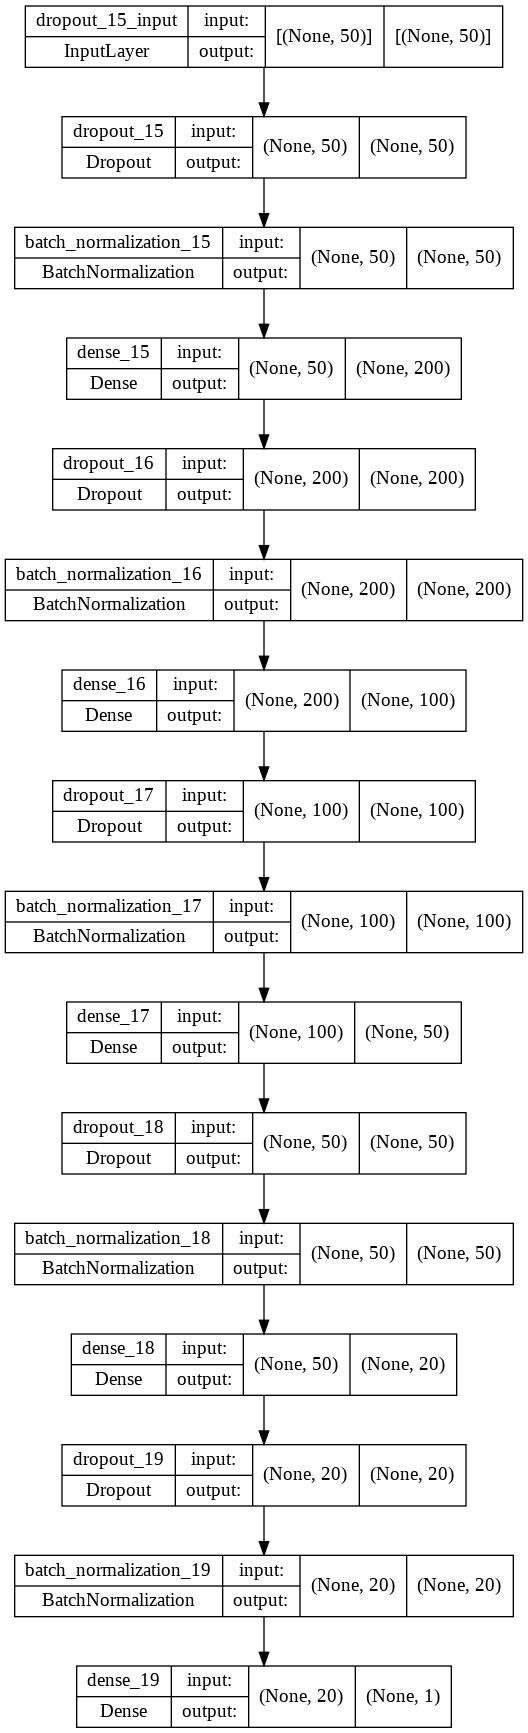

In [ ]:
keras.utils.plot_model(model1,show_shapes=True)

In [ ]:
np.mean(average_val_acc_history)

0.78465482989947

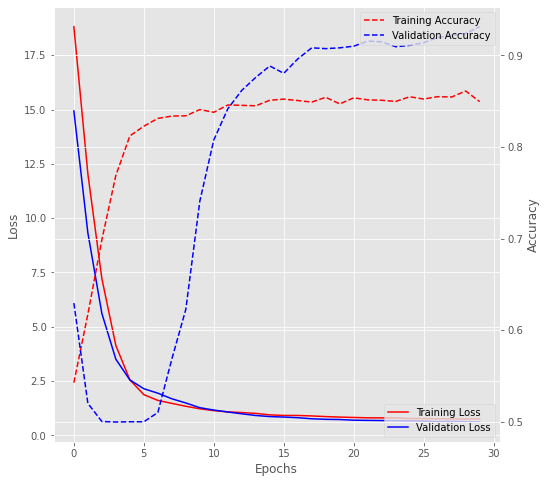

In [ ]:
# plot loss and accuracy on train, validation data

plt.style.use('ggplot')

fig, ax=plt.subplots(figsize=(8,8))
ax.plot(average_loss_history,c='r', label="Training Loss")
ax.plot(average_val_loss_history,c='b', label="Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend(['Training Loss','Validation Loss'], loc="lower right")

ax2=ax.twinx()
ax2.plot(average_acc_history,c="r",linestyle="dashed", label="Training Accuracy")
ax2.plot(average_val_acc_history,c='b',linestyle="dashed", label="Validation Accuracy")
ax2.set_ylabel("Accuracy")
ax2.legend(["Training Accuracy", "Validation Accuracy"], loc="upper right")

plt.show()

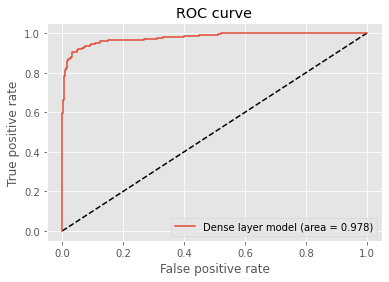

In [ ]:
from sklearn.metrics import roc_curve
y_pred1 = model1.predict(X_test_dvs).ravel()
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred1)

from sklearn.metrics import auc
auc_1 = auc(fpr_1, tpr_1)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1, tpr_1, label='Dense layer model (area = {:.3f})'.format(auc_1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# evaluate the model by using test data
loss_metrics = model1.evaluate(X_test_dvs,y_test,verbose=1)

22/22 [==============================] - 0s 6ms/step - loss: 0.6419 - accuracy: 0.9033


* Output layer activation function: Sigmoid 

* Loss function: Adam

* Metric: Accuracy

# **5. 1D Consolutional Neural Network**

In [ ]:
# Before building CNN model, vectorize facts data
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, 
    output_mode="int",
    output_sequence_length = 500
)

text_vectorization.adapt(X_train)

X_train_processed = text_vectorization(X_train)
X_test_processed = text_vectorization(X_test)

In [ ]:
# Build cnn model
def cnn_model():    
  input = keras.Input(shape=(500))
  x = layers.Embedding(input_dim=2000,output_dim=8,input_length=500, mask_zero=True)(input)
  x = layers.Conv1D(filters=40,kernel_size=10,activation="relu")(x)
  x = layers.MaxPool1D(pool_size=2,strides=2)(x)
  x = layers.GlobalAveragePooling1D()(x) 
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(10,activation="relu")(x)
  x = layers.Dropout(0.2)(x)
  output = layers.Dense(1, activation="sigmoid")(x)

  model = keras.Model(inputs=input,outputs=output)

  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
# train and cross validate the model
k = 4
num_validation_samples = len(X_train_dvs) // k
num_epochs = 30
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = X_train_processed[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train_processed[:num_validation_samples * fold],
        X_train_processed[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model2 = cnn_model()

    history2 = model2.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes)

    val_loss_history2 = history2.history['val_loss']
    val_acc_history2 = history2.history['val_accuracy']
    loss_history2 = history2.history['loss']
    acc_history2 = history2.history['accuracy']
    all_val_loss_histories.append(val_loss_history2)
    all_loss_histories.append(loss_history2)
    all_val_acc_histories.append(val_acc_history2)
    all_acc_histories.append(acc_history2)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/30
51/51 [==============================] - 3s 36ms/step - loss: 0.6906 - accuracy: 0.5136 - val_loss: 0.6857 - val_accuracy: 0.4947
Epoch 2/30
51/51 [==============================] - 2s 32ms/step - loss: 0.6620 - accuracy: 0.5822 - val_loss: 0.6272 - val_accuracy: 0.6438
Epoch 3/30
51/51 [==============================] - 2s 32ms/step - loss: 0.5617 - accuracy: 0.7592 - val_loss: 0.5091 - val_accuracy: 0.8320
Epoch 4/30
51/51 [==============================] - 2s 32ms/step - loss: 0.4373 - accuracy: 0.8573 - val_loss: 0.3964 - val_accuracy: 0.8663
Epoch 5/30
51/51 [==============================] - 2s 32ms/step - loss: 0.3162 - accuracy: 0.9184 - val_loss: 0.2993 - val_accuracy: 0.9030
Epoch 6/30
51/51 [==============================] - 2s 32ms/step - loss: 0.2334 - accuracy: 0.9361 - val_loss: 0.2494 - val_accuracy: 0.9136
Epoch 7/30
51/51 [==============================] - 2s 32ms/step - loss: 0.1834 - accuracy: 0.9523 - val_loss: 0.2125 - val_accuracy: 0.9325
Epoch 8/30
51

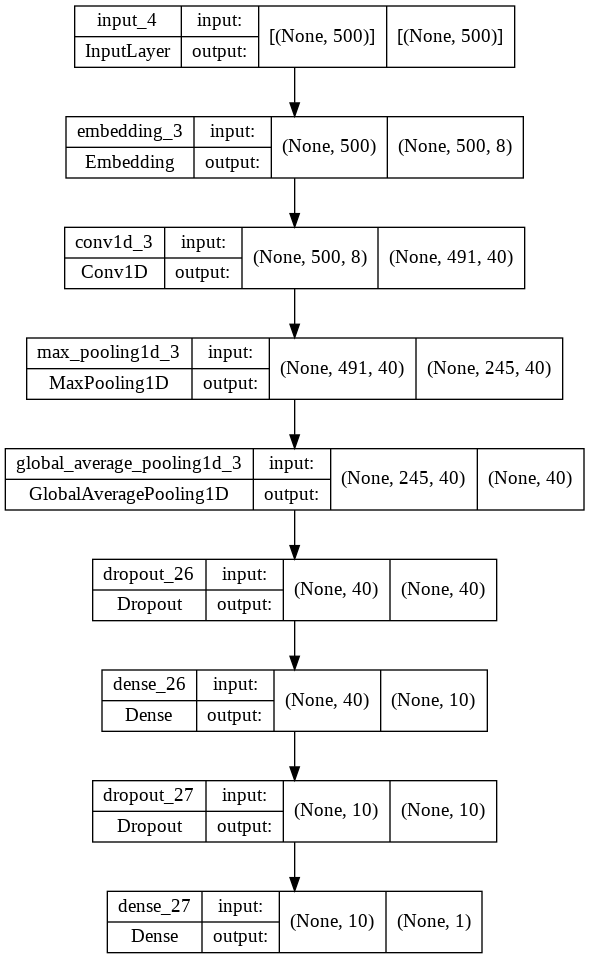

In [ ]:
keras.utils.plot_model(model2,show_shapes=True)

In [ ]:
np.mean(average_val_acc_history)

0.9155128193398316

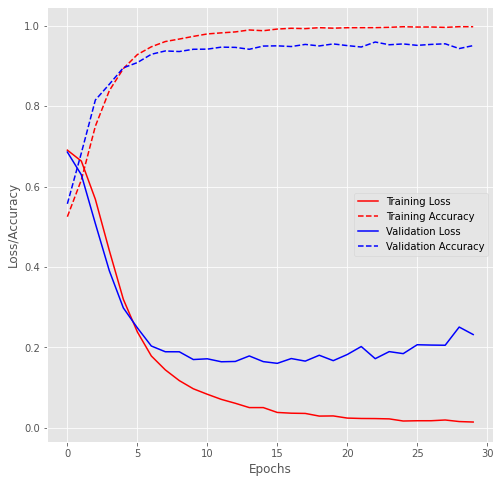

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(8,8))
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
loss_metrics = model2.evaluate(X_test_processed,y_test,verbose=1)

22/22 [==============================] - 0s 6ms/step - loss: 0.4567 - accuracy: 0.9120


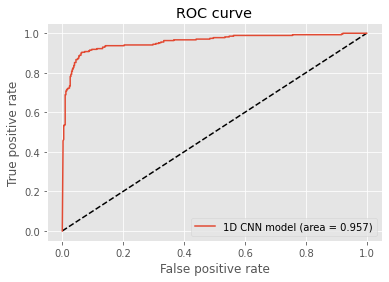

In [ ]:
from sklearn.metrics import roc_curve
y_pred2 = model2.predict(X_test_processed).ravel()
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred2)

from sklearn.metrics import auc
auc_2 = auc(fpr_2, tpr_2)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_2, tpr_2, label='1D CNN model (area = {:.3f})'.format(auc_2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

* Output layer activation function: Sigmoid

* Loss function: Adam

* Metric: Accuracy

# **6. Dense layer with Text Vectorization layer**

## 2-grams + TD-IDF

In [ ]:
text_vectorization_bi_tfidf = keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode = "tf_idf",
    # standardize=custom_standardization_fn,
    # split=custom_split_fn
)

In [ ]:
text_vectorization_bi_tfidf.adapt(X_train)  

In [ ]:
binary_2gram_tfidf_text = text_vectorization_bi_tfidf(X_train)
binary_2gram_tfidf_text

<tf.Tensor: shape=(3382, 20000), dtype=float32, numpy=
array([[ 430.4736   ,    4.859286 ,    1.3988298, ...,    0.       ,
           0.       ,    0.       ],
       [ 614.21234  ,   15.966226 ,    9.791809 , ...,    0.       ,
           0.       ,    0.       ],
       [ 619.46204  ,   11.801123 ,    4.1964893, ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [1144.4298   ,   22.213879 ,   11.190639 , ...,    0.       ,
           0.       ,    0.       ],
       [ 572.2149   ,    9.024388 ,    5.5953193, ...,    0.       ,
           0.       ,    0.       ],
       [ 398.97552  ,    5.5534697,    2.0982447, ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)>

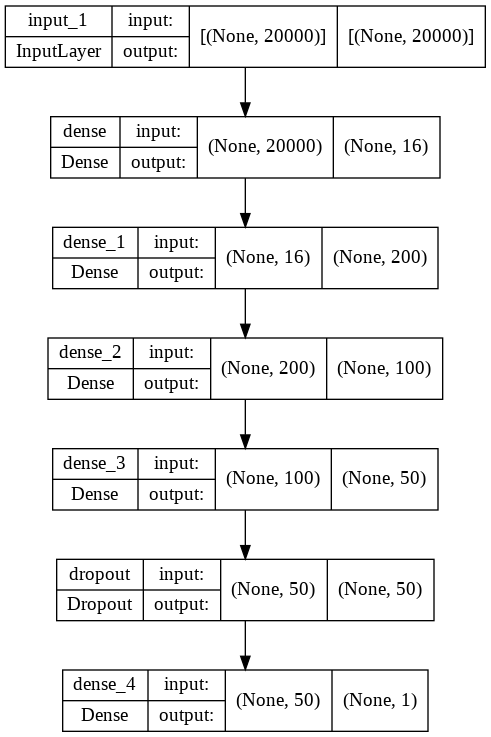

In [ ]:
max_tokens=20000
hidden_dim=16

def td_idf_model():
    inputs = keras.Input(shape=(max_tokens,))
    x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dense(200, activation="relu")(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dense(50, activation="tanh")(x)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])


    return model 

model_bi_tfidf = td_idf_model()
keras.utils.plot_model(model_bi_tfidf,show_shapes=True)

In [ ]:
k = 4
num_validation_samples = len(X_train) // k
num_epochs = 25
batch_sizes = 50
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = binary_2gram_tfidf_text[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        binary_2gram_tfidf_text[:num_validation_samples * fold],
        binary_2gram_tfidf_text[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    
    model_bi_tfidf = td_idf_model()
    callbacks = [keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
      ]
    history = model_bi_tfidf.fit(training_data, training_targets, 
                    validation_data = (validation_data,validation_targets), 
                    epochs=num_epochs, batch_size=batch_sizes,callbacks=callbacks)
    #model = keras.models.load_model("tfidf_2gram.keras")

    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Epoch 1/25
51/51 [==============================] - 2s 18ms/step - loss: 0.3016 - accuracy: 0.8691 - val_loss: 0.0692 - val_accuracy: 0.9811
Epoch 2/25
51/51 [==============================] - 1s 14ms/step - loss: 0.0603 - accuracy: 0.9838 - val_loss: 0.0385 - val_accuracy: 0.9905
Epoch 3/25
51/51 [==============================] - 1s 15ms/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0416 - val_accuracy: 0.9882
Epoch 4/25
51/51 [==============================] - 1s 13ms/step - loss: 0.0085 - accuracy: 0.9980 - val_loss: 0.0404 - val_accuracy: 0.9917
Epoch 5/25
51/51 [==============================] - 1s 16ms/step - loss: 4.7398e-04 - accuracy: 1.0000 - val_loss: 0.0327 - val_accuracy: 0.9953
Epoch 6/25
51/51 [==============================] - 1s 15ms/step - loss: 1.2251e-04 - accuracy: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9953
Epoch 7/25
51/51 [==============================] - 1s 13ms/step - loss: 3.6909e-05 - accuracy: 1.0000 - val_loss: 0.0456 - val_accuracy: 0.9953
E

In [ ]:
np.mean(average_val_acc_history)

0.9883905291557312

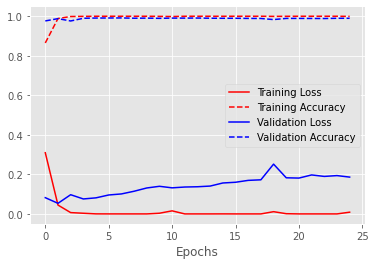

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
binary_2gram_tf_test = text_vectorization_bi_tfidf(X_test)
binary_2gram_tf_test

<tf.Tensor: shape=(693, 20000), dtype=float32, numpy=
array([[ 409.47488  ,    6.2476535,    2.0982447, ...,    0.       ,
           0.       ,    0.       ],
       [ 341.22906  ,    4.165102 ,    4.1964893, ...,    0.       ,
           0.       ,    0.       ],
       [ 797.95105  ,   20.131327 ,    4.8959045, ...,    0.       ,
           0.       ,    0.       ],
       ...,
       [1065.6847   ,   13.18949  ,    5.5953193, ...,    0.       ,
           0.       ,    0.       ],
       [ 157.49034  ,   20.825512 ,    7.693564 , ...,    0.       ,
           0.       ,    0.       ],
       [ 388.4762   ,   11.801123 ,    3.4970746, ...,    0.       ,
           0.       ,    0.       ]], dtype=float32)>

In [ ]:
 model_bi_tfidf.evaluate(binary_2gram_tf_test, y_test)

22/22 [==============================] - 0s 3ms/step - loss: 0.3593 - accuracy: 0.9798


[0.35931357741355896, 0.9797979593276978]

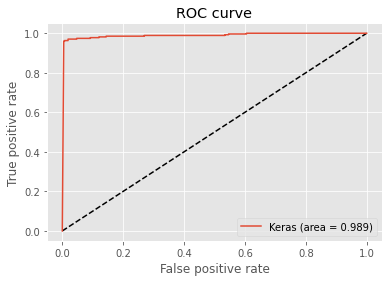

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_bi_tfidf.predict(binary_2gram_tf_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# **7. Recurrent Neural Network**

- In fact, before we use the RNN models, we checked the ratio of observations in training to mean number of tokens per sample equal to 3 (< 1500). Thus, We can’t expect to get much value using a sequence model, since we would need a larger dataset (1,500,000 samples). But, we still try to add RNN layers to validate our hypothesis by comparing accuracy and AUC scores.

## Bidirectional LSTM (No Embeddings)



In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # maximum tokens are set to 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(df['facts'])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-03-16 17:22:45.544717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-16 17:22:45.545395: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-16 17:22:45.601086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-16 17:22:45.673552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


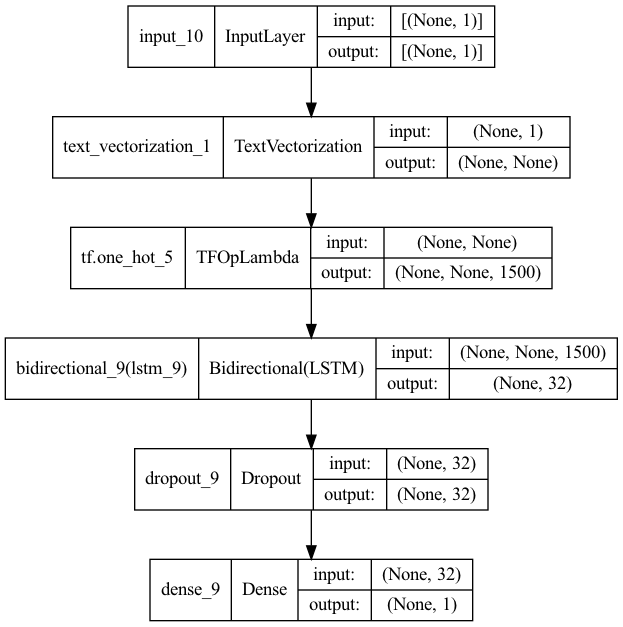

In [ ]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=1500) # we one-hot encode those, so it becomes a length x1500 vector.
    x = layers.Bidirectional(layers.LSTM(16))(one_hot) # operating in parallel and generate 32 LSTM (embeddings) in the end
    x = layers.Dropout(0.5)(x) # prevent the overfitting
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_lstm = build_model()

keras.utils.plot_model(model_lstm, show_shapes=True)

In [ ]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 25
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []  
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history. 
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm = build_model()
        history = model_lstm.fit(training_data, training_targets, 
                            validation_data = (validation_data,validation_targets), 
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]   

Epoch 1/25


2022-03-16 17:23:03.771297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5207

2022-03-16 17:23:24.759004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 26s 2s/step - loss: 0.6922 - accuracy: 0.5207 - val_loss: 0.6909 - val_accuracy: 0.5018
Epoch 2/25
11/11 [==============================] - 22s 2s/step - loss: 0.6904 - accuracy: 0.5475 - val_loss: 0.6854 - val_accuracy: 0.6556
Epoch 3/25
11/11 [==============================] - 24s 2s/step - loss: 0.6811 - accuracy: 0.6114 - val_loss: 0.6652 - val_accuracy: 0.6970
Epoch 4/25
11/11 [==============================] - 25s 2s/step - loss: 0.6474 - accuracy: 0.6910 - val_loss: 0.6252 - val_accuracy: 0.6379
Epoch 5/25
11/11 [==============================] - 25s 2s/step - loss: 0.6193 - accuracy: 0.7067 - val_loss: 0.5854 - val_accuracy: 0.7219
Epoch 6/25
11/11 [==============================] - 21s 2s/step - loss: 0.5617 - accuracy: 0.7596 - val_loss: 0.6882 - val_accuracy: 0.5420
Epoch 7/25
11/11 [==============================] - 22s 2s/step - loss: 0.5351 - accuracy: 0.7651 - val_loss: 0.6164 - val_accuracy: 0.6130
Epoch 8/25
11/11 [=============

2022-03-16 17:32:19.929597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5152

2022-03-16 17:32:41.257213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 26s 2s/step - loss: 0.6920 - accuracy: 0.5152 - val_loss: 0.6918 - val_accuracy: 0.4757
Epoch 2/25
11/11 [==============================] - 23s 2s/step - loss: 0.6885 - accuracy: 0.5499 - val_loss: 0.6868 - val_accuracy: 0.6083
Epoch 3/25
11/11 [==============================] - 23s 2s/step - loss: 0.6772 - accuracy: 0.6484 - val_loss: 0.6605 - val_accuracy: 0.6959
Epoch 4/25
11/11 [==============================] - 25s 2s/step - loss: 0.6436 - accuracy: 0.6788 - val_loss: 0.6133 - val_accuracy: 0.7053
Epoch 5/25
11/11 [==============================] - 30s 3s/step - loss: 0.5979 - accuracy: 0.7324 - val_loss: 0.5711 - val_accuracy: 0.7101
Epoch 6/25
11/11 [==============================] - 25s 2s/step - loss: 0.5712 - accuracy: 0.7446 - val_loss: 0.5982 - val_accuracy: 0.6852
Epoch 7/25
11/11 [==============================] - 26s 2s/step - loss: 0.5306 - accuracy: 0.7848 - val_loss: 0.6209 - val_accuracy: 0.6675
Epoch 8/25
11/11 [=============

2022-03-16 17:42:57.017872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.5104

2022-03-16 17:43:20.338862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 29s 3s/step - loss: 0.6928 - accuracy: 0.5104 - val_loss: 0.6918 - val_accuracy: 0.4840
Epoch 2/25
11/11 [==============================] - 25s 2s/step - loss: 0.6903 - accuracy: 0.5479 - val_loss: 0.6885 - val_accuracy: 0.5692
Epoch 3/25
11/11 [==============================] - 26s 2s/step - loss: 0.6820 - accuracy: 0.6114 - val_loss: 0.6750 - val_accuracy: 0.5905
Epoch 4/25
11/11 [==============================] - 29s 3s/step - loss: 0.6646 - accuracy: 0.6330 - val_loss: 0.6430 - val_accuracy: 0.6438
Epoch 5/25
11/11 [==============================] - 31s 3s/step - loss: 0.6386 - accuracy: 0.6906 - val_loss: 0.6303 - val_accuracy: 0.7243
Epoch 6/25
11/11 [==============================] - 34s 3s/step - loss: 0.6255 - accuracy: 0.6882 - val_loss: 0.5950 - val_accuracy: 0.7716
Epoch 7/25
11/11 [==============================] - 28s 3s/step - loss: 0.5949 - accuracy: 0.7395 - val_loss: 0.7199 - val_accuracy: 0.5266
Epoch 8/25
11/11 [=============

2022-03-16 17:53:51.675309: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.5065

2022-03-16 17:54:14.931532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 29s 2s/step - loss: 0.6934 - accuracy: 0.5065 - val_loss: 0.6904 - val_accuracy: 0.5834
Epoch 2/25
11/11 [==============================] - 28s 3s/step - loss: 0.6893 - accuracy: 0.5771 - val_loss: 0.6884 - val_accuracy: 0.4947
Epoch 3/25
11/11 [==============================] - 23s 2s/step - loss: 0.6841 - accuracy: 0.5960 - val_loss: 0.6784 - val_accuracy: 0.6556
Epoch 4/25
11/11 [==============================] - 25s 2s/step - loss: 0.6600 - accuracy: 0.6665 - val_loss: 0.6143 - val_accuracy: 0.7053
Epoch 5/25
11/11 [==============================] - 27s 3s/step - loss: 0.5900 - accuracy: 0.7221 - val_loss: 0.5960 - val_accuracy: 0.6994
Epoch 6/25
11/11 [==============================] - 24s 2s/step - loss: 0.5498 - accuracy: 0.7564 - val_loss: 0.5596 - val_accuracy: 0.7396
Epoch 7/25
11/11 [==============================] - 23s 2s/step - loss: 0.5236 - accuracy: 0.7639 - val_loss: 0.6356 - val_accuracy: 0.5964
Epoch 8/25
11/11 [=============

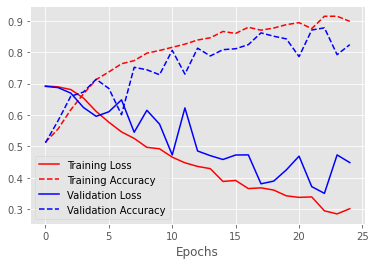

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
model_lstm.evaluate(X_test, y_test)

2022-03-16 18:06:31.355828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:06:31.487290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:06:31.502671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 35s 2s/step - loss: 0.6812 - accuracy: 0.6104


[0.6812437176704407, 0.6103895902633667]

2022-03-16 18:08:43.397205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:08:43.488768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:08:43.533301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


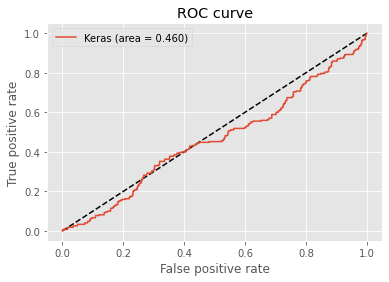

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Textual Embeddings

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=1000, # set the maximum tokens at 1000 words
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    ngrams =1 # set ngram = 1 (which means we will consider the seqenuce of the documents)
)

text_vectorization.adapt(df['facts'])

2022-03-16 18:09:41.561779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
with tf.device('/cpu:0'):
    def build_model_text_embed():
        inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
        processing = text_vectorization(inputs)

        #we are setting 1000 as the vocabulary size, as we will be encoding numbers 0 to 999. 
        #We want the length of the word vector to be 8, hence output_dim is set to 8. 
        # The length of the input sequence to embedding layer will be 500.
        # Truncates after 500 tokens, and pads up to 500 tokens for shorter facts.
        # Mask zero means it will skip 0 tokens and will not pass them on.
        x = layers.Embedding(input_dim=1000,output_dim=8,input_length=500, mask_zero=True)(processing) # Embedding layer
        x = layers.Bidirectional(layers.LSTM(12))(x) #Bidirectional LSTM layer: # operating in parallel and generate 10 LSTM (embeddings) in the end 
        x = keras.layers.Dropout(0.5)(x)
        outputs = layers.Dense(1, activation="sigmoid")(x)
    
    
        model = keras.Model(inputs,outputs)
        model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
        return model

    model_lstm_text_embed = build_model_text_embed()

    keras.utils.plot_model(model_lstm_text_embed, show_shapes=True)

In [ ]:
with tf.device('/cpu:0'):
    k = 4
    num_validation_samples = len(X_train) // k
    num_epochs = 25
    batch_sizes = 250
    all_loss_histories = []
    all_val_loss_histories = []  
    all_acc_histories = []
    all_val_acc_histories = []

    # For each validation fold, we will train a full set of epochs, and store the history. 
    for fold in range(k):
        validation_data = X_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        validation_targets = y_train[num_validation_samples * fold:
                            num_validation_samples * (fold + 1)]
        training_data = np.concatenate([
            X_train[:num_validation_samples * fold],
            X_train[num_validation_samples * (fold + 1):]])
        training_targets = np.concatenate([
            y_train[:num_validation_samples * fold],
            y_train[num_validation_samples * (fold + 1):]])
        model_lstm_text_embed = build_model_text_embed()
        history = model_lstm_text_embed.fit(training_data, training_targets, 
                            validation_data = (validation_data,validation_targets), 
                            epochs=num_epochs, batch_size=batch_sizes)
        val_loss_history = history.history['val_loss']
        val_acc_history = history.history['val_accuracy']
        loss_history = history.history['loss']
        acc_history = history.history['accuracy']
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_val_acc_histories.append(val_acc_history)
        all_acc_histories.append(acc_history)

    average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
    average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
    average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
    average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]   

Epoch 1/25


2022-03-16 18:14:59.200866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5093

2022-03-16 18:15:02.635724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 7s 319ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6921 - val_accuracy: 0.4947
Epoch 2/25
11/11 [==============================] - 2s 168ms/step - loss: 0.6912 - accuracy: 0.5380 - val_loss: 0.6901 - val_accuracy: 0.6781
Epoch 3/25
11/11 [==============================] - 2s 171ms/step - loss: 0.6883 - accuracy: 0.6315 - val_loss: 0.6871 - val_accuracy: 0.7101
Epoch 4/25
11/11 [==============================] - 2s 175ms/step - loss: 0.6843 - accuracy: 0.6736 - val_loss: 0.6823 - val_accuracy: 0.7089
Epoch 5/25
11/11 [==============================] - 2s 179ms/step - loss: 0.6759 - accuracy: 0.6953 - val_loss: 0.6725 - val_accuracy: 0.6722
Epoch 6/25
11/11 [==============================] - 2s 182ms/step - loss: 0.6550 - accuracy: 0.6941 - val_loss: 0.6289 - val_accuracy: 0.7432
Epoch 7/25
11/11 [==============================] - 2s 170ms/step - loss: 0.6006 - accuracy: 0.7138 - val_loss: 0.5658 - val_accuracy: 0.7349
Epoch 8/25
11/11 

2022-03-16 18:15:53.312701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5223

2022-03-16 18:15:57.681993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 9s 393ms/step - loss: 0.6920 - accuracy: 0.5223 - val_loss: 0.6919 - val_accuracy: 0.4757
Epoch 2/25
11/11 [==============================] - 2s 166ms/step - loss: 0.6886 - accuracy: 0.5365 - val_loss: 0.6882 - val_accuracy: 0.6533
Epoch 3/25
11/11 [==============================] - 2s 179ms/step - loss: 0.6848 - accuracy: 0.6626 - val_loss: 0.6848 - val_accuracy: 0.5858
Epoch 4/25
11/11 [==============================] - 2s 166ms/step - loss: 0.6779 - accuracy: 0.6464 - val_loss: 0.6777 - val_accuracy: 0.6462
Epoch 5/25
11/11 [==============================] - 2s 186ms/step - loss: 0.6662 - accuracy: 0.7048 - val_loss: 0.6605 - val_accuracy: 0.6426
Epoch 6/25
11/11 [==============================] - 2s 185ms/step - loss: 0.6249 - accuracy: 0.7119 - val_loss: 0.6618 - val_accuracy: 0.5964
Epoch 7/25
11/11 [==============================] - 2s 182ms/step - loss: 0.5771 - accuracy: 0.7627 - val_loss: 0.5514 - val_accuracy: 0.8107
Epoch 8/25
11/11 

2022-03-16 18:16:50.155350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5333

2022-03-16 18:16:53.695052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 8s 319ms/step - loss: 0.6924 - accuracy: 0.5333 - val_loss: 0.6914 - val_accuracy: 0.6544
Epoch 2/25
11/11 [==============================] - 2s 186ms/step - loss: 0.6907 - accuracy: 0.5798 - val_loss: 0.6895 - val_accuracy: 0.5325
Epoch 3/25
11/11 [==============================] - 2s 175ms/step - loss: 0.6868 - accuracy: 0.5806 - val_loss: 0.6818 - val_accuracy: 0.7503
Epoch 4/25
11/11 [==============================] - 2s 171ms/step - loss: 0.6751 - accuracy: 0.6555 - val_loss: 0.6607 - val_accuracy: 0.5870
Epoch 5/25
11/11 [==============================] - 2s 175ms/step - loss: 0.6443 - accuracy: 0.6673 - val_loss: 0.6283 - val_accuracy: 0.6651
Epoch 6/25
11/11 [==============================] - 2s 182ms/step - loss: 0.6077 - accuracy: 0.7052 - val_loss: 0.6738 - val_accuracy: 0.5657
Epoch 7/25
11/11 [==============================] - 2s 176ms/step - loss: 0.5676 - accuracy: 0.7592 - val_loss: 0.5546 - val_accuracy: 0.6828
Epoch 8/25
11/11 

2022-03-16 18:17:45.025199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5349

2022-03-16 18:17:48.428123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 7s 334ms/step - loss: 0.6924 - accuracy: 0.5349 - val_loss: 0.6916 - val_accuracy: 0.4923
Epoch 2/25
11/11 [==============================] - 2s 186ms/step - loss: 0.6895 - accuracy: 0.5325 - val_loss: 0.6877 - val_accuracy: 0.7136
Epoch 3/25
11/11 [==============================] - 2s 183ms/step - loss: 0.6837 - accuracy: 0.6389 - val_loss: 0.6695 - val_accuracy: 0.6118
Epoch 4/25
11/11 [==============================] - 2s 182ms/step - loss: 0.6445 - accuracy: 0.6772 - val_loss: 0.6008 - val_accuracy: 0.7893
Epoch 5/25
11/11 [==============================] - 2s 180ms/step - loss: 0.5855 - accuracy: 0.7804 - val_loss: 0.5567 - val_accuracy: 0.7953
Epoch 6/25
11/11 [==============================] - 2s 179ms/step - loss: 0.5546 - accuracy: 0.7958 - val_loss: 0.5275 - val_accuracy: 0.7953
Epoch 7/25
11/11 [==============================] - 2s 180ms/step - loss: 0.5255 - accuracy: 0.7982 - val_loss: 0.5166 - val_accuracy: 0.7716
Epoch 8/25
11/11 

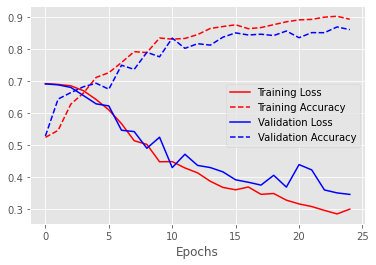

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
model_lstm_text_embed.evaluate(X_test, y_test)

2022-03-16 18:24:15.078611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:24:15.423306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:24:15.490934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 37s 2s/step - loss: 0.6753 - accuracy: 0.6104


[0.6752784848213196, 0.6103895902633667]

2022-03-16 18:24:57.052446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:24:57.333951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-16 18:24:57.394601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


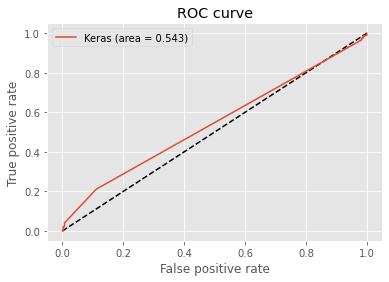

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model_lstm_text_embed.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Pre-trained Embeddings

* There are multiple pretrained models we can use for text data, such as GloVe, Word2Vec, FastText, LSA. 
* After exploring these models, we decided to use **GloVe** for this legal data in that GloVe is an extension to the word2vec method for efficiently learning word vectors and it combine global statistics of matrix factorization techniques with the local context-based learning.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-03-17 00:23:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-17 00:23:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-17 00:23:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = "glove.6B.100d.txt" 
  
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) 
        coefs = np.fromstring(coefs, "f", sep=" ") 
        embeddings_index[word] = coefs 
  
glove_vec_lengths = len(coefs)

print(f"Found {len(embeddings_index)} word vectors.")
print(f"GloVe vector representations are {glove_vec_lengths} elements long.")

Found 400000 word vectors.
GloVe vector representations are 100 elements long.


In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=4000, # Setting max token as 4000
    output_mode="int", 
)

text_vectorization.adapt(df['facts'])

In [ ]:
embedding_dim = glove_vec_lengths 
vocabulary = text_vectorization.get_vocabulary() # From the vocabulary go over every word.
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # Make a dictionary

# Instantiate a matrix of values (these will be the weights in our embedding layer)
embedding_matrix = np.zeros((len(vocabulary), embedding_dim)) # 4000 tokens by 100
for word, i in word_index.items():
    if i < len(vocabulary):
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Creating embedding layer that will put into keras model.
embedding_layer = layers.Embedding(
    len(vocabulary), # 4000 words.
    glove_vec_lengths, # Vectors of 100 elements per word.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # Initialize with fixed values from matrix.
    trainable=False, # Weights will be freezed and not update during training.
    mask_zero=True, # We don't pass 0 tokens for padding through the layer.
)

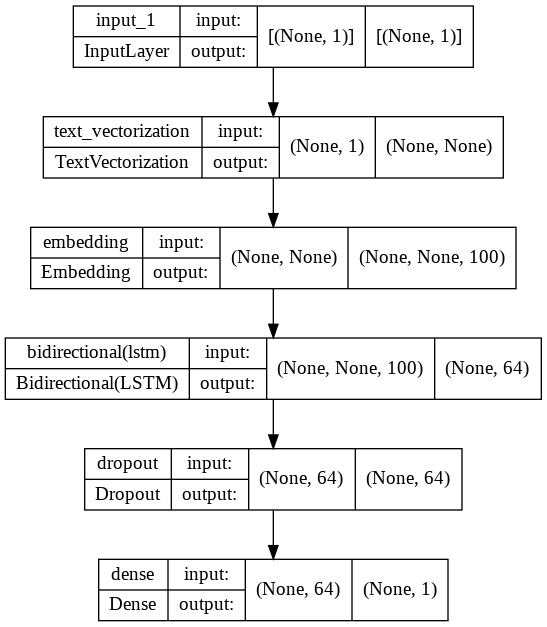

In [ ]:
def build_model_GloVe():
    inputs = keras.layers.Input(shape=(1), dtype="string") # strings as input 
    processing = text_vectorization(inputs) # Text vectorization layer
    
    embedding = embedding_layer(processing) # GloVe embedding layer

    x = keras.layers.Bidirectional(keras.layers.LSTM(32))(embedding) #Bidirectional LSTM layer
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model_GloVe = build_model_GloVe()

keras.utils.plot_model(model_GloVe, show_shapes=True)

In [ ]:
k = 4
num_validation_samples = len(X_train) // k
num_epochs = 25
batch_sizes = 512
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = X_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = y_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        X_train[:num_validation_samples * fold],
        X_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        y_train[:num_validation_samples * fold],
        y_train[num_validation_samples * (fold + 1):]])
    model_GloVe = build_model_GloVe()
    history = model_GloVe.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes, verbose=0)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

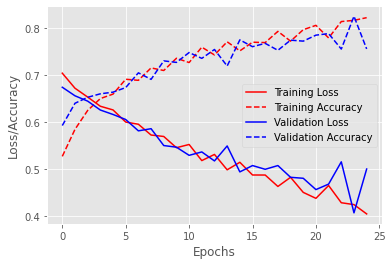

In [ ]:
plt.style.use('ggplot')
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()

In [ ]:
model_GloVe = build_model_GloVe()
model_GloVe.fit(X_train, y_train,
                epochs=20, batch_size=512, verbose=0)
test_acc = model_GloVe.evaluate(X_test, y_test)[1]*100
print(f'The resulting model is about {test_acc:.2f}% accurate in the holdout sample.')

22/22 [==============================] - 5s 106ms/step - loss: 0.3704 - accuracy: 0.8355
The resulting model is about 83.55% accurate in the holdout sample.


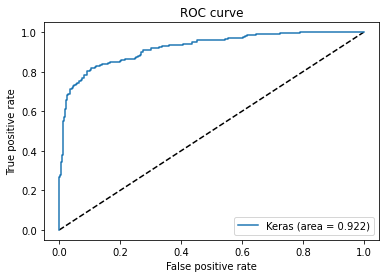

In [ ]:
from sklearn.metrics import roc_curve
y_pred_glove = model_GloVe.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_glove)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# **6. Conclusion**


## Model Selection & Interpretation

* **Best model**: Dense layer with text-vectorizatoin(bigram, TD-IDF) performed best(AUC) among our models
  * **Sigmoid/Binary-crossentrophy**: Since our prediction problem was binary classification, we used sigmoid output activation function that it returns values between 0 and 1, which can be treated as probabilities of a data point belonging to binary class. Likewise, we used binary-crossentrophy as loss function.
  * **Test accuracy/AUC**: We measured test accuracy for each model. To choose best model, we generated AUC.

* **LIME**: We used LIMe to explain our model and to see what words in text contributed to the prediction

In [ ]:
# Create lime explainer
try:
  import lime
  from lime.lime_text import LimeTextExplainer
except ImportError as error:
  !pip install lime
  import lime
  from lime.lime_text import LimeTextExplainer

X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

class_names=['petitioner_winning','respondent_winning']
explainer=LimeTextExplainer(class_names=class_names)

def new_predict(text):
  vectorized = text_vectorization_bi_tfidf(text)
  padded = keras.preprocessing.sequence.pad_sequences(vectorized, maxlen=20000,padding='post')
  pred=model_bi_tfidf.predict(padded)
  pos_neg_preds = []
  for i in pred:
    temp=i[0]
    pos_neg_preds.append(np.array([1-temp,temp])) #I would recommend rounding temp and 1-temp off to 2 places
  return np.array(pos_neg_preds)

     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=036d7e62313f81ec585cf9b3677de467f00801d2adb7f80cd66fe9af21b3c1ef
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
test_obs = 500

if y_test_array[test_obs]==0:
  print(f'The ground truth label for this observation is "petitioner winning."')
else:
  print(f'The ground truth label for this observation is "respondent winning."')

explainer.explain_instance(X_test_array[test_obs],new_predict).show_in_notebook(text=True)

The ground truth label for this observation is "respondent winning."


## Suggestion

* **Cross-validation with upsampled data**: For better measurement, we could have done upsampling manually in each cross validation folds. However, since our goal was exploring multiple NN models, upsampling in each folds hurted runtime efficiency and code-reuse. We decided to upsample train set first. As we kept test set aside, we obtained a valid measure of model performance on test set.

* **Domain specific pretrained model**: We could further work using domain specific pretrained model. We found https://github.com/ashkonf/LeGloVe, which is python implementation of GloVe word vectors for legal domain-specific corpuses.

* **Gather more features**: In Oyez database, we could find more information such as advocate, location, lower court and date. Gathering this information as new features might be able to improve our model performance.